# Compressed sensing using GMMs on GNFUV dataset 

Dataset found at: https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data+Set+2#
The data-set comprises (4) sets of mobile sensor readings data (humidity, temperature) corresponding to a swarm of four (4) Unmanned Surface Vehicles (USVs).
The swarm of the USVs is moving according to a GPS pre-defined trajectory, whose relative way-points are in the figure. The USVs are floating over the sea surface in a coastal area of Athens (Greece).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os
import pandas 

Reused code from Nimay's BTP code  

In [2]:
def weighted_l2(v, mat):
    if np.linalg.matrix_rank(mat) < mat.shape[0]:
        m = v.T @ np.linalg.pinv(mat) @ v
    else:
        # print("hi ", np.linalg.det(mat), np.linalg.matrix_rank(mat))
        m = v.T @ np.linalg.inv(mat) @ v
    return m

def decode(model, A, y, sigma = 1e-7):
    x_hat = np.empty(model.means_.shape)
    cost = []
    var_noise = sigma * np.eye(A.shape[0])

    for j in range(model.means_.shape[0]):
        var_j, mu_j = model.covariances_[j], model.means_[j]
        x_hat_j = var_j @ A.T @ np.linalg.inv(A @ var_j @ A.T + var_noise) @ (y - A @ mu_j) + mu_j
        # print(np.linalg.det(var_j))
        # print(var_j)
        try:
            cost_j = weighted_l2(y - A @ x_hat_j, var_noise) + weighted_l2(x_hat_j - mu_j, var_j) + np.log(np.linalg.det(var_j),where=np.linalg.det(var_j)>0)
        except:
            print("y - A @ x_hat_j",y - A @ x_hat_j , "\n", var_noise,"\n",y,A)
        # print(np.linalg.det(var_j))
        x_hat[j] = x_hat_j
        cost.append(cost_j)

    j = np.argmin(cost)
    # print(j)
    return x_hat[j]

def PSNR(x_, x_t):
    assert x_.shape == x_t.shape
    peak = np.max(x_) - np.min(x_)
    mse = np.mean(((x_ - x_t)/peak)**2, axis=1)
    print(type(mse),mse)
    psnr = -10*np.log10(mse)
    return np.mean(psnr), np.min(psnr), np.max(psnr), np.std(psnr)

def plot_data(xs, ys, path = 'PSNR.png', ylabel='Avg PSNR'):
    plt.plot(xs, ys, marker="o")
    plt.xlabel('# of measurements')
    plt.ylabel(ylabel)
    plt.grid(True)
    for x,y in zip(xs,ys):
        label = f"({x},{round(y,2)})"
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(-5,10), ha='center')
#     plt.tight_layout()
    plt.savefig(path)
    plt.close()
    

In [3]:
def mmse(model, A, sigma = 1e-5):
    cost = 0
    var_noise = sigma * np.eye(A.shape[0])
    for j in range(model.means_.shape[0]):
        var_j = model.covariances_[j]
        m_j = np.trace(var_j - var_j @ A.T @ np.linalg.inv(A @ var_j @ A.T + var_noise) @ A @ var_j)
        cost += model.weights_[j] * m_j
    return cost

def optimize_mat(model, A_):
    A = A_.copy()
    costs = []
    for it in tqdm(range(20)):
        cnt = 0
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                # flip the bit only if mmse is reduced
                cost = mmse(model, A)
                A[i, j] = 1 - A[i, j]
                cnt += 1
                if cost <= mmse(model, A):
                    A[i, j] = 1 - A[i, j]
                    cnt -= 1
        # break the loop if no improvement
        if cnt == 0:
            break
        costs.append(mmse(model, A))
    return A

The time-series data of GNFUV dataset is arranged in arrays of patches, for patch_size = 40, we will take 20 time-instances and make an array \[ temperature_1, humidity_1, ... , temperature_20, humidity_20 \]

In [4]:
############## Patch size
patch_size = 20*2
compression_ratio = 5

### Data preprocessing
Dataset has some empty values, which we remove. We also sort the dataset by the time, since we would transmit temporally close data. 

In [5]:
full_data = []

for experiment_number  in [1,2]:
    
    for USV_number in [2,3,4]:
        path = "CNFUV_Datasets/Datasets/Data_Experiment_%d/pi%d.xlsx"% (experiment_number, USV_number)
        dataframe = pandas.read_excel(path)

        dataframe = dataframe.mask(dataframe.eq(" None")).dropna()
        dataframe = dataframe.mask(dataframe.eq("None")).dropna()
        dataframe = dataframe.sort_values(by=['time'])
        dataframe = dataframe[['Humidity','Temperature']]
        
        dataframe = dataframe[:(dataframe.shape[0]//patch_size)*patch_size]
        data = dataframe.to_numpy().flatten()
        data = data.reshape(-1,patch_size)
        print(data.shape)
        full_data.extend(data)
full_data = np.array(full_data)


(76, 40)
(44, 40)
(88, 40)
(28, 40)
(40, 40)
(50, 40)


We divide the dataset into 90:10 train:test ratio and set other parameters

In [6]:
n_train = full_data.shape[0]//10 *9
print(n_train,full_data.shape[0])
n_test = full_data.shape[0] - n_train
n_component_overall = 5
cnt = 5
n_init = 5

to_train = 1
use_mat = 0

np.random.shuffle(data)
train_data = full_data[:n_train]
test_data = full_data[n_train:]

288 326


In [7]:
print("full_data.shape: ",full_data.shape)
print("len(train_data): ",len(train_data))
print("len(test_data): ",len(test_data))

full_data.shape:  (326, 40)
len(train_data):  288
len(test_data):  38


Now, we consider the unoptimised case and the optimised case. In the optimised case, we iterate over a range of possible n_components to get the best fit using the BIC criteria. We also use the sensing matrix optimisation. 

In [8]:

m = int(patch_size/compression_ratio)
A  = np.random.binomial(1, 0.5, size=(m,patch_size))

unoptimised = 0
optimised = 0
val_signal_mean = 0
y_err = []
y_err_opt = []
y_err_opt2 = []
runs = 1
folder_name = 'GNFUV_results/latest/'
for k in range(runs):
    if to_train:
        model = GaussianMixture(n_components=n_component_overall, n_init=n_init,  max_iter=200, init_params='random')
        model.fit(train_data)
        
        lowest_bic = np.infty
        bic = []
        n_components_range = range(1, 10)

        for n_component in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(
                n_components=n_component, n_init=n_init,  max_iter=200,
            )
            gmm.fit(train_data)
            bic.append(gmm.bic(train_data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                n_component_overall = n_component
        model_opt = best_gmm
        print("n_component_overall: ",n_component_overall)
    
    patch_err = []
    patch_err_opt = []
    patch_err_opt2 = []
    model_opt = best_gmm
    model_opt2 = model
    A_opt = optimize_mat(model_opt, A)
    A_opt2 = optimize_mat(model, A)
    
# test_data = np.random.randint(20,50,size=(n_test,len(train_data[0])))
# test_data = full_test_data
    
    mm = int((m*4)/5 ) 
    num_deviations = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        y = A @ x
        x_hat = decode(model, A[:mm], y[:mm])
        patch_err.append(np.linalg.norm(x - np.round(x_hat), ord=1)/np.linalg.norm(x, ord=1) ) 
        
        y_opt = A_opt @ x
        x_hat_opt = decode(model, A_opt[:mm], y_opt[:mm])
        patch_err_opt.append(np.linalg.norm(x - np.round(x_hat_opt), ord=1)/np.linalg.norm(x, ord=1) ) 
        
        
        y_opt2 = A_opt2 @ x
        x_hat_opt2 = decode(model, A_opt2[:mm], y_opt2[:mm])
        patch_err_opt2.append(np.linalg.norm(x - np.round(x_hat_opt2), ord=1)/np.linalg.norm(x, ord=1) ) 

        y_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat, ord=1))
        y_err_opt.append(np.linalg.norm(y_opt[mm:] - A_opt[mm:] @ x_hat_opt, ord=1))
        y_err_opt2.append(np.linalg.norm(y_opt2[mm:] - A_opt2[mm:] @ x_hat_opt2, ord=1))
        if y_err_opt[-1] > 5:
            num_deviations += 1
            if num_deviations == 10:
                print("Detected drift")
                # update distribution 
                num_deviations = 0
        else:
            num_deviations = 0
    
print("Done")

n_component_overall:  8


  5%|████▏                                                                              | 1/20 [01:24<26:52, 84.85s/it]


Done


Print the percentage errors for the unoptimised and optimised case

In [9]:
# print(patch_err)
print("Percentage error: " ,np.mean(patch_err)*100, np.mean(patch_err_opt)*100,np.mean(patch_err_opt2)*100)
# print("y_err: ",np.mean(y_err),"\n",y_err)
# print("y_err_opt: ",np.mean(y_err_opt),"\n", y_err_opt)

Percentage error:  0.06111300106918147 0.03914959358131641 0.04067651209674763


Play a sound after a long simulation ends to alert the user that it is completed

In [10]:
import winsound
duration = 2000  # milliseconds
freq = 540  # Hz
winsound.Beep(freq, duration)

[765 697 598 639 623 520 744 722 864 941 887 895 567 888 822 648 743 541
 959 885 871 919 872 723 692 690 1059 794 723 690 691 723 669 717 585 936
 823 554 672 690] [26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 47 26 48
 27 48 27 48 27 48 27 48 27 48 27 48 27 48 27 48] 
x_hat [26.29479985 47.965308   25.99848102 47.83765146 26.08082496 48.35545893
 26.18987356 48.34186728 26.12611805 48.23575278 25.56803476 47.66808485
 26.27749152 48.1704127  25.97237485 48.2835414  25.70830143 47.94671592
 25.71055261 47.72313894 25.8668503  46.91268536 25.74124282 48.27388249
 26.83168711 47.97911026 27.07366362 48.03419209 27.06980511 47.85546021
 26.88206003 47.79484446 27.18924279 47.99927758 26.98434107 47.84372575
 27.1531264  47.84369524 26.99373216 47.99931347]
[765 697 598 639 623 520 744 722 864 941 887 895 567 888 822 648 743 541
 959 885 871 919 872 723 692 690 1059 794 723 690 691 723 669 717 585 936
 823 554 672 690] [26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 48 26 

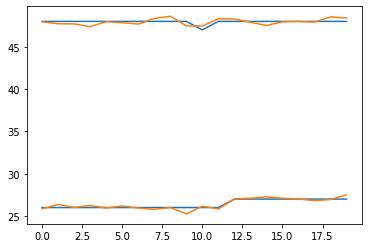

In [11]:
plt.plot(x[::2], label='Original', color='C0')
plt.plot(x_hat_opt[::2], label='Reconstructed', color='C1')
print(y,x,"\nx_hat",x_hat)
plt.plot(x[1::2], label='Original', color='C0')
plt.plot(x_hat_opt[1::2], label='Reconstructed', color='C1')
print(y,x,"\nx_hat",x_hat)


In [16]:
test_data = []

for experiment_number  in [2]:
    
    for USV_number in [5]:
        path = "CNFUV_Datasets/Datasets/Data_Experiment_%d/pi%d.xlsx"% (experiment_number, USV_number)
        dataframe = pandas.read_excel(path)

        dataframe = dataframe.mask(dataframe.eq(" None")).dropna()
        dataframe = dataframe.mask(dataframe.eq("None")).dropna()
        dataframe = dataframe.sort_values(by=['time'])
        dataframe = dataframe[['Humidity','Temperature']]
        
        dataframe = dataframe[:(dataframe.shape[0]//patch_size)*patch_size]
        data = dataframe.to_numpy().flatten()
        data = data.reshape(-1,patch_size)
        print(data.shape)
        test_data.extend(data)
test_data = np.array(test_data)
overall_temp = []
overall_temp_hat = []
for j in range(len(test_data)):
    x = test_data[j]
    x_hat = np.zeros(x.shape)
    y_opt = A_opt @ x
    x_hat_opt = decode(model, A_opt[:mm], y_opt[:mm])
    overall_temp.extend(x[::2])
    overall_temp_hat.extend(x_hat_opt[::2])
    
overall_temp_hat = np.round(overall_temp_hat)

(70, 40)


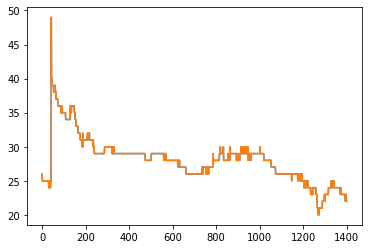

In [17]:
plt.plot(overall_temp, label='Original', color='C0')
plt.plot(overall_temp_hat, label='Reconstructed', color='C1')
# print(y,x,"\nx_hat",x_hat)
# plt.plot(x[1::2], label='Original', color='C0')
# plt.plot(x_hat_opt[1::2], label='Reconstructed', color='C1')
# print(y,x,"\nx_hat",x_hat)

In [18]:
print(np.linalg.norm(overall_temp - np.round(overall_temp_hat), ord=1)/np.linalg.norm(overall_temp, ord=1) ) 

0.0


In [52]:
data_path = 'Temperature iot data/kanpur.csv'
dataframe = pandas.read_csv(data_path)
dataframe = dataframe[['FeelsLikeC', 'humidity']]
print(dataframe.shape)
dataframe = dataframe[:(dataframe.shape[0]//patch_size)*patch_size]
data = dataframe.to_numpy().flatten()
test_data = data.reshape(-1,patch_size)
test_data = test_data[100:200]
print(test_data.shape)
y_err_opt = []
y_err = []
y_err_opt2 = []
patch_err_opt2 = []
patch_err = []
patch_err_opt = []
print(data)
for j in range(len(test_data)):
    x = test_data[j]
    x_hat = np.zeros(x.shape)
    y = A @ x
    x_hat = decode(model, A[:mm], y[:mm])
    patch_err.append(np.linalg.norm(x - np.round(x_hat), ord=1)/np.linalg.norm(x, ord=1) ) 

    y_opt = A_opt @ x
    x_hat_opt = decode(model, A_opt[:mm], y_opt[:mm])
    patch_err_opt.append(np.linalg.norm(x - np.round(x_hat_opt), ord=1)/np.linalg.norm(x, ord=1) ) 


    y_opt2 = A_opt2 @ x
    x_hat_opt2 = decode(model, A_opt2[:mm], y_opt2[:mm])
    patch_err_opt2.append(np.linalg.norm(x - np.round(x_hat_opt2), ord=1)/np.linalg.norm(x, ord=1) ) 

    y_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat, ord=1))
    y_err_opt.append(np.linalg.norm(y_opt[mm:] - A_opt[mm:] @ x_hat_opt, ord=1))
    y_err_opt2.append(np.linalg.norm(y_opt2[mm:] - A_opt2[mm:] @ x_hat_opt2, ord=1))
    print("y_err_opt: ",y_err_opt[-1],"x: ",x,"x_hat: ",np.round(x_hat_opt))
    if y_err_opt[-1] > 5:
        num_deviations += 1
        if num_deviations == 10:
            print("Detected drift")
            # update distribution 
            num_deviations = 0
    else:
        num_deviations = 0
    
print("Done")

(96432, 2)
(100, 40)
[11 50 12 ... 33 19 34]
y_err_opt:  57.35236189135634 x:  [28 25 30 23 31 22 33 20 34 19 33 20 32 21 30 22 29 27 27 32 26 38 26 40
 25 42 25 44 25 46 25 47 25 49 23 52 22 54 22 57] x_hat:  [29. 23. 28. 25. 32. 24. 33. 23. 36. 17. 31. 21. 32. 21. 31. 20. 29. 24.
 32. 36. 26. 36. 29. 37. 24. 39. 24. 43. 23. 47. 27. 46. 25. 48. 26. 54.
 21. 51. 19. 54.]
y_err_opt:  94.30970955123439 x:  [24 52 26 46 27 41 29 35 31 28 32 22 32 19 32 16 33 13 31 14 30 14 29 14
 28 16 26 19 24 21 24 24 24 27 24 30 23 32 23 34] x_hat:  [26. 53. 26. 47. 27. 44. 23. 33. 33. 34. 28. 22. 34. 23. 34. 12. 34. 14.
 31. 11. 31. 11. 29. 14. 27. 15. 30. 18. 20. 26. 20. 26. 26. 29. 26. 32.
 20. 32. 21. 32.]
y_err_opt:  61.43030138681587 x:  [22 35 22 38 21 40 20 42 23 36 24 31 27 25 28 22 30 20 32 17 32 17 33 17
 33 17 32 19 31 20 29 22 28 25 27 27 26 30 26 32] x_hat:  [18. 39. 23. 39. 21. 41. 20. 38. 24. 31. 24. 27. 28. 24. 30. 23. 32. 20.
 29. 17. 33. 17. 33. 20. 34. 16. 32. 19. 30. 17. 34. 23. 32

y_err_opt:  23.20550690016924 x:  [42  5 41  5 40  6 39  6 37  7 34  8 32 10 31 10 30 11 29 12 29 12 29 12
 28 13 28 13 27 14 27 14 29 13 30 12 32 10 35  9] x_hat:  [43.  4. 41.  5. 40.  5. 39.  7. 36.  8. 35.  9. 32. 10. 30. 11. 29. 11.
 30. 12. 29. 12. 29. 11. 28. 14. 28. 13. 28. 14. 26. 13. 28. 13. 29. 12.
 33. 10. 35. 11.]
y_err_opt:  31.202054359395646 x:  [38  8 41  6 42  6 44  5 45  5 45  5 45  6 44  6 41  7 37  8 34  9 33 10
 32 10 31 11 30 12 30 12 29 13 28 13 27 14 26 14] x_hat:  [39.  6. 40.  6. 42.  5. 44.  6. 45.  5. 44.  6. 45.  6. 43.  6. 40.  6.
 39.  9. 34.  9. 34.  8. 32. 10. 30. 11. 30. 13. 30. 12. 27. 13. 28. 14.
 28. 13. 25. 15.]
y_err_opt:  28.294422654457662 x:  [29 13 32 12 34 11 38 10 41 10 45  9 45  8 46  7 47  6 46  6 45  7 43  7
 40  8 37 10 35 11 34 11 33 11 32 11 31 11 30 11] x_hat:  [30. 12. 32. 12. 35. 11. 37. 10. 42. 13. 44. 10. 45.  8. 46.  7. 47.  7.
 45.  5. 45.  7. 43.  7. 39.  8. 39.  9. 35. 12. 32. 10. 33. 11. 32. 11.
 30. 11. 30. 13.]
y_err_opt: 

y_err_opt:  87.34163120385222 x:  [33 32 32 34 32 38 31 43 30 47 30 50 30 52 30 55 31 51 33 48 34 44 36 39
 38 33 40 28 39 28 38 29 37 30 37 30 38 30 38 30] x_hat:  [33. 31. 30. 33. 31. 37. 35. 44. 28. 40. 32. 50. 29. 52. 28. 55. 29. 51.
 37. 52. 34. 45. 38. 37. 40. 32. 34. 29. 39. 27. 43. 31. 34. 29. 36. 30.
 43. 30. 38. 28.]
y_err_opt:  178.45009778732413 x:  [37 32 36 35 35 37 34 39 33 41 33 42 32 45 31 49 31 52 30 55 30 59 30 62
 32 57 34 51 36 46 38 37 41 29 44 21 43 20 42 19] x_hat:  [37. 27. 39. 32. 37. 32. 41. 35. 32. 35. 35. 42. 31. 42. 24. 52. 29. 56.
 32. 54. 29. 64. 34. 60. 33. 60. 29. 52. 39. 40. 43. 35. 35. 29. 44. 22.
 47. 22. 45. 25.]
y_err_opt:  46.89734499880137 x:  [42 18 41 18 40 18 40 19 38 22 37 25 35 28 34 30 33 33 33 35 32 38 32 40
 31 42 31 44 31 46 31 47 32 43 34 39 36 36 39 30] x_hat:  [42. 15. 41. 20. 42. 19. 42. 21. 39. 22. 36. 27. 34. 27. 35. 30. 35. 31.
 36. 38. 31. 38. 35. 38. 30. 41. 31. 43. 32. 46. 32. 42. 33. 42. 36. 39.
 33. 35. 37. 30.]
y_err_opt:  

y_err_opt:  36.180163633054576 x:  [40 24 39 27 39 30 39 33 40 30 42 28 43 26 45 22 48 19 50 15 50 14 50 14
 51 13 50 14 49 14 47 15 46 17 44 19 42 21 42 22] x_hat:  [38. 27. 39. 27. 38. 30. 39. 32. 40. 27. 42. 26. 43. 25. 46. 23. 48. 19.
 47. 15. 51. 15. 48. 16. 52. 13. 50. 14. 49. 12. 50. 16. 48. 17. 44. 19.
 41. 21. 43. 19.]
Detected drift
y_err_opt:  58.60197145268131 x:  [41 24 41 25 40 26 40 26 39 27 38 29 38 30 37 31 39 29 42 27 44 25 46 22
 49 19 51 16 51 16 50 16 50 15 51 15 52 14 52 13] x_hat:  [42. 25. 41. 23. 39. 25. 39. 28. 37. 31. 40. 30. 38. 31. 37. 31. 38. 30.
 41. 25. 43. 25. 44. 22. 49. 21. 51. 17. 53. 18. 45. 16. 48. 16. 48. 13.
 54. 14. 53. 17.]
y_err_opt:  129.73280490099592 x:  [48 16 44 18 40 20 38 21 37 21 36 22 36 23 36 24 36 25 34 25 32 25 30 25
 34 21 39 17 43 14 48 12 53 11 58  9 55  9 53  8] x_hat:  [47. 15. 45. 16. 41. 17. 42. 18. 36. 15. 37. 20. 36. 22. 32. 26. 35. 27.
 36. 25. 31. 27. 33. 24. 36. 22. 34. 19. 43. 10. 53. 13. 50. 11. 59. 11.
 59. 11. 55.  

In [198]:
data_path = 'Temperature iot data/pune.csv'
dataframe = pandas.read_csv(data_path)
dataframe = dataframe[['FeelsLikeC', 'humidity']]
print(dataframe.shape)
dataframe = dataframe[:(dataframe.shape[0]//patch_size)*patch_size]
data = dataframe.to_numpy().flatten()

compression_ratio = 2.5
m = int(patch_size/compression_ratio)
A  = np.random.binomial(1, 0.5, size=(m,patch_size))



runs = 1
folder_name = 'GNFUV_results/latest/'
for k in range(runs):
    if to_train:
        model = GaussianMixture(n_components=n_component_overall, n_init=n_init,  max_iter=200, init_params='random')
        model.fit(train_data)
        
        lowest_bic = np.infty
        bic = []
        n_components_range = range(1, 10)

        for n_component in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(
                n_components=n_component, n_init=n_init,  max_iter=200,
            )
            gmm.fit(train_data)
            bic.append(gmm.bic(train_data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                n_component_overall = n_component
        model_opt = best_gmm
        print("n_component_overall: ",n_component_overall)
    
    
    model_opt = best_gmm
    model_opt2 = model
    A_opt = optimize_mat(model_opt, A)
    A_opt2 = optimize_mat(model, A)
    

(96432, 2)
n_component_overall:  5


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:17<00:05,  1.15s/it]


In [223]:
data_path = 'Temperature iot data/bengaluru.csv'
dataframe = pandas.read_csv(data_path)
dataframe = dataframe[['FeelsLikeC', 'humidity']]
print(dataframe.shape)
dataframe = dataframe[:(dataframe.shape[0]//patch_size)*patch_size]
data = dataframe.to_numpy().flatten()
test_data = data.reshape(-1,patch_size)
test_data = test_data[500:1000]

(96432, 2)


In [224]:
# test_data = np.random.randint(20,50,size=(n_test,len(train_data[0])))
# test_data = full_test_data
y_err = []
y_err_opt = []
y_err_opt2 = []
patch_err = []
patch_err_opt = []
patch_err_opt2 = []
mm = int((m*4)/5 ) 
num_deviations = 0
for j in range(len(test_data)):
    x = test_data[j]
    x_hat = np.zeros(x.shape)
    y = A @ x
    x_hat = decode(model, A[:mm], y[:mm])
    patch_err.append(np.linalg.norm(x - np.round(x_hat), ord=1)/np.linalg.norm(x, ord=1) ) 

    y_opt = A_opt @ x
    x_hat_opt = decode(model, A_opt[:mm], y_opt[:mm])
    patch_err_opt.append(np.linalg.norm(x - np.round(x_hat_opt), ord=1)/np.linalg.norm(x, ord=1) ) 


    y_opt2 = A_opt2 @ x
    x_hat_opt2 = decode(model, A_opt2[:mm], y_opt2[:mm])
    patch_err_opt2.append(np.linalg.norm(x - np.round(x_hat_opt2), ord=1)/np.linalg.norm(x, ord=1) ) 


    y_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat, ord=1))
    y_err_opt.append(np.linalg.norm(y_opt[mm:] - A_opt[mm:] @ x_hat_opt, ord=1))
    y_err_opt2.append(np.linalg.norm(y_opt2[mm:] - A_opt2[mm:] @ x_hat_opt2, ord=1))
    if y_err_opt[-1] > 15:
        num_deviations += 1
        if num_deviations == 10:
            print("Detected drift")
            # update distribution 
            num_deviations = 0
    else:
        num_deviations = max(num_deviations-1,0)
    

print("Done")

Done


In [225]:
y_err_opt

[10.743012076252398,
 7.39922584919691,
 4.486001328243674,
 20.34472332821474,
 7.705971092490813,
 9.324755054005209,
 24.512064257311295,
 11.581409000819576,
 9.29174341924329,
 8.092773642704515,
 5.4142217727716115,
 22.449339552331594,
 15.608006535010759,
 8.885347451392704,
 6.768245088150934,
 9.649490654598253,
 21.486112905236382,
 21.25969033920802,
 21.860103209779027,
 16.461893277806553,
 8.126861039313326,
 18.507398574929198,
 15.905682197511965,
 30.164179933184528,
 4.156185898659146,
 6.5483603557047445,
 12.519077512223475,
 3.642282512867723,
 21.94546188758875,
 15.607163448095548,
 16.54775929813934,
 22.292390433056994,
 18.900311563267792,
 18.24174924598384,
 11.460900338977638,
 23.413446000292083,
 18.923306605475318,
 6.497726878651861,
 21.224845371190554,
 11.075092922897966,
 13.440800204611719,
 6.96360840149589,
 28.634488482182746,
 13.969436175460942,
 12.665785712905631,
 23.193734719505187,
 10.407830419127038,
 25.903182493905376,
 11.2597139767

In [208]:
patch_err_opt

[0.017826825127334467,
 0.008547008547008548,
 0.01533494753833737,
 0.01263001485884101,
 0.015691868758915834,
 0.009129213483146067,
 0.018867924528301886,
 0.007751937984496124,
 0.009416195856873822,
 0.008604206500956023,
 0.01588785046728972,
 0.016736401673640166,
 0.0136986301369863,
 0.005818181818181818,
 0.013478818998716302,
 0.005948446794448116,
 0.0066273932253313695,
 0.018043684710351376,
 0.011009174311926606,
 0.02081268582755203,
 0.009097801364670205,
 0.020437956204379562,
 0.027048528241845664,
 0.00967741935483871,
 0.022682445759368838,
 0.0036596523330283625,
 0.014782608695652174,
 0.011294526498696786,
 0.003336113427856547,
 0.012295081967213115,
 0.021645021645021644,
 0.012903225806451613,
 0.012030075187969926,
 0.016507384882710686,
 0.018885741265344664,
 0.00916590284142988,
 0.013966480446927373,
 0.0066518847006651885,
 0.010901162790697675,
 0.007898894154818325,
 0.010703363914373088,
 0.028996865203761754,
 0.01602136181575434,
 0.00216606498194

In [203]:
np.mean(patch_err_opt)

0.009762150880545712

In [204]:
x

array([42, 14, 39, 18, 37, 22, 34, 25, 32, 32, 30, 39, 29, 46, 28, 52, 28,
       58, 27, 64, 27, 65, 27, 66, 27, 67, 26, 68, 24, 70, 23, 71, 27, 60,
       29, 48, 31, 36, 36, 29], dtype=int64)

In [205]:
np.round(x_hat_opt)

array([41., 15., 39., 18., 37., 22., 35., 26., 32., 32., 30., 39., 28.,
       46., 27., 52., 27., 58., 27., 64., 27., 65., 27., 66., 26., 67.,
       26., 68., 25., 70., 24., 71., 27., 59., 29., 48., 32., 36., 35.,
       28.])

Code dump ( partially modified code, older version code, users other than the coder can ignore) 

In [15]:
ms = patch_size//5
B = A_opt
for iter,m in tqdm(enumerate(ms)):
    mm = (m*4)//5
    dev_counts = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x
            x_hat = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat)
            if e_cv > (y_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            dev_counts.append(deviation_count)
        reconstruction[j] = x_hat

TypeError: 'int' object is not iterable